# WiDS 2025
### Sex Patterns in ADHD

### Import

In [1]:
import pandas as pd
import numpy as np
import math

from sklearn.linear_model import MultiTaskElasticNetCV, LogisticRegression, RidgeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.pipeline import make_pipeline, Pipeline


import seaborn as sns
import matplotlib.pyplot as plt

# Multi-output
from sklearn.multioutput import MultiOutputClassifier

# Multi-task
from sklearn.linear_model import MultiTaskElasticNetCV


In [2]:
source = "TRAIN"
connectome_train = pd.read_csv(f"{source}/{source}_FUNCTIONAL_CONNECTOME_MATRICES.csv")
cat_train = pd.read_csv(f"{source}/{source}_CATEGORICAL_METADATA.csv")
quan_train = pd.read_csv(f"{source}/{source}_QUANTITATIVE_METADATA.csv")
label = pd.read_csv(f"{source}/TRAINING_SOLUTIONS.csv")

In [3]:
source = "TEST"
connectome_test = pd.read_csv(f"{source}/{source}_FUNCTIONAL_CONNECTOME_MATRICES.csv")
cat_test = pd.read_csv(f"{source}/{source}_CATEGORICAL.csv")
quan_test = pd.read_csv(f"{source}/{source}_QUANTITATIVE_METADATA.csv")

In [4]:
train = connectome_train.merge(quan_train, on= 'participant_id').merge(cat_train, on= 'participant_id')
train.head(5)

test = connectome_train.merge(quan_test, on= 'participant_id').merge(cat_test, on= 'participant_id')


In [5]:
train.set_index('participant_id',inplace=True)
test.set_index('participant_id',inplace=True)
label.set_index('participant_id',inplace=True)

In [6]:
pd.DataFrame(train.isnull().sum(), columns=['null_count']).query('null_count > 0')

,null_count
MRI_Track_Age_at_Scan,360
PreInt_Demos_Fam_Child_Ethnicity,11


In [7]:
# Filter out the row index of 
'''null_index = train[train.isnull().any(axis=1)].index

train = train[~train.index.isin(null_index)]
label = label[~label.index.isin(null_index)]'''

'null_index = train[train.isnull().any(axis=1)].index\n\ntrain = train[~train.index.isin(null_index)]\nlabel = label[~label.index.isin(null_index)]'

In [8]:
train = train.drop(['PreInt_Demos_Fam_Child_Ethnicity', 'MRI_Track_Age_at_Scan'], axis =1)

### EDA

Cleaning checklist:

Null: ?. Null Var importance? 

Each Var Normal Range -> Detect Anomalies -> remove or something else

Data Type: Check categorical to have uniformed labels. check normal range if coded. Norminal type -> one-hot-code, ordinal -> label encode ()



In [9]:
label.ADHD_Outcome.value_counts()
# 383 neg, 831 pos

ADHD_Outcome
1    831
0    382
Name: count, dtype: int64

In [10]:
label.Sex_F.value_counts()
# 797 M, 416 F

Sex_F
0    797
1    416
Name: count, dtype: int64

In [11]:
pd.crosstab(label['ADHD_Outcome'], label['Sex_F'], normalize='all')

Sex_F,0,1
ADHD_Outcome,,
0,0.178071,0.136851
1,0.478978,0.206101


In [12]:
pd.crosstab(label['ADHD_Outcome'], label['Sex_F'])

Sex_F,0,1
ADHD_Outcome,,
0,216,166
1,581,250


# Model Train
Baseline model: Multi-output pipeline for same model.
- Logistic Reg with L1 norm for sparsity and inference enhancement
- NN with 2 output nodes with binary classifier activiation function (Sigmoid)

Performance: Multi-task models with shared features for correlated tasks.
- Multitask Lasso or multitask Elastic Net

### Train - test split


In [13]:
x_train, x_test, y_train, y_test = train_test_split(train, label, test_size=0.3, random_state=527)


In [14]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(849, 19925)
(364, 19925)
(849, 2)
(364, 2)


In [15]:
pd.DataFrame(x_train.isnull().sum(), columns=['null_count']).query('null_count > 0')

,null_count


In [16]:
y_train.dtypes

ADHD_Outcome    int64
Sex_F           int64
dtype: object

### Visual call-out Functions

In [26]:
def model_stats(y_test, y_pred, model_name):
    """
    Compute and display important performance metrics for a classification model, 
    including F1-score, sensitivity, specificity, and a confusion matrix heatmap.

    Parameters:
    -----------
    y_test : array-like or Series (Truth)
    y_pred : array-like or Series (Model prediction)
    model_name : str

    Outputs:
    --------
    - Prints the F1-score, sensitivity (recall), and specificity.
    - Displays a heatmap of the confusion matrix for easier interpretation.

    Usage:
    ------
    1. Pass `y_test` and `y_pred` as arrays (or pandas Series).
    2. Provide a descriptive `model_name`(model and dataset used) to label the confusion matrix plot.
    """
    classes = ['Negative', 'positive']
    cm = confusion_matrix(y_test, y_pred)
    print('f1: ', f1_score(y_test, y_pred))

    # Compute confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate sensitivity and specificity
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)

    # Print results
    print(f"Sensitivity (Recall/True Positive Rate): {sens:.2f}")
    print(f"Specificity (True Negative Rate): {spec:.2f}")


    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix of {model_name}")
    plt.show()

### Multi-output pipeline
Perform the same model for both tasks

In [17]:
model = MultiOutputClassifier(make_pipeline(
                              StandardScaler(),                                      
                              LogisticRegression(penalty='l1', solver='liblinear')))

model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print('f1: ', f1_score(y_test,y_pred, average = 'micro'))

f1:  0.6088117489986649


In [24]:
model

MultiOutputClassifier(estimator=Pipeline(steps=[('standardscaler',
                                                 StandardScaler()),
                                                ('logisticregression',
                                                 LogisticRegression(penalty='l1',
                                                                    solver='liblinear'))]))

f1:  0.732965009208103
Sensitivity (Recall/True Positive Rate): 0.80
Specificity (True Negative Rate): 0.17


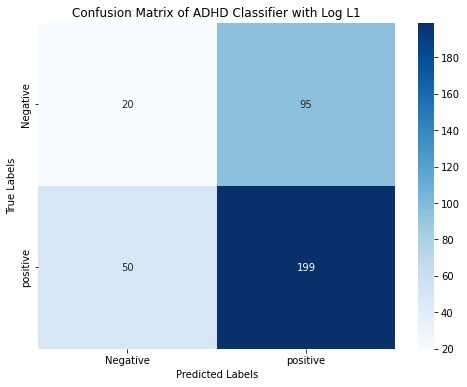

In [29]:
model_stats(y_test['ADHD_Outcome'], y_pred[:,0], "ADHD Classifier with Log L1")